In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [2]:
DATASET_PATH = '../downloads/TACO/data'
anns_file_path = DATASET_PATH + '/' + 'annotations.json'

In [3]:
from models.resnet34_yolo import resnet34_yolo as used_model
import config
import torch

folder = "../runs/ResNet/dropout-0.1/2023-02-12_14-14-14"
path_to_model = folder + "/model.pt"
path_to_export = folder + "/model.onnx"
dropout = 0.1

cfg = config.Config().replace(DROPOUT=0.1, BATCH_SIZE=8)
model = used_model(split_size=cfg.SPLIT_SIZE, num_boxes=cfg.NUM_BOXES, num_classes=cfg.NUM_CLASSES, dropout_percentage=dropout).to(cfg.DEVICE)
model.load_state_dict(torch.load(path_to_model, map_location=torch.device(cfg.DEVICE)))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
from utils import numel

print('Number of parameters: %d' % numel(model))

Number of parameters: 25594203


In [5]:
IMAGE_SIZE = 448

data_preprocess = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

In [6]:
from utils import (
    plot_image,
    cellboxes_to_boxes,
    non_max_suppression,
)
from taco_dataset import CoCoDatasetForYOLO
import pandas as pd

test_dataset = CoCoDatasetForYOLO(
    root=DATASET_PATH,
    annFile=anns_file_path,
    transform=data_preprocess,
    C=1
)

test_df = pd.read_csv(cfg.test_indices_path)
test_indices = torch.tensor(test_df['test_indices'].values)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


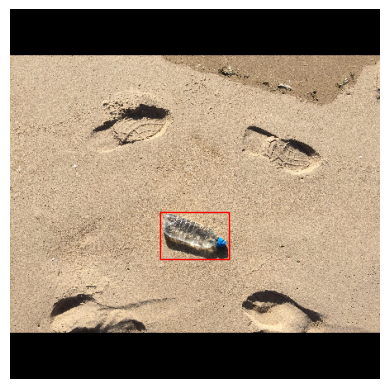

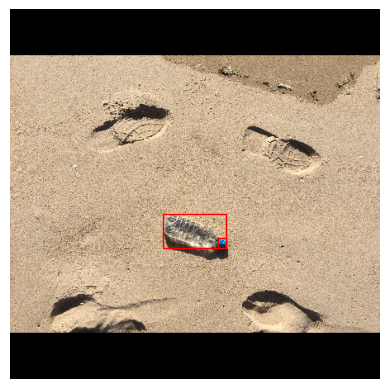

In [66]:
import torchvision.transforms as transforms
import random

idx = random.randint(0, len(test_dataset))
data = test_dataset[idx]

pred = model(data[0].unsqueeze(0))
pred = cellboxes_to_boxes(pred, S=7, B=2, C=1)
pred = non_max_suppression(pred[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

transform = transforms.ToPILImage()
plot_image(transform(data[0]), pred)

bboxes = cellboxes_to_boxes(torch.tensor([data[1].tolist()]), S=7, B=2, C=1)
bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

transform = transforms.ToPILImage()
plot_image(transform(data[0]), bboxes)

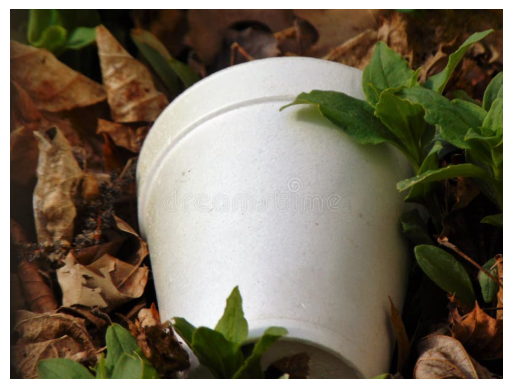

In [48]:
from PIL import Image
import numpy as np
SAMPLE_IMAGE_DIR = '../downloads/sample_image_3.jpg'

sample_image = Image.open(SAMPLE_IMAGE_DIR)
preprocessed_image = data_preprocess(image=np.array(sample_image), bboxes=[])["image"].unsqueeze(0)

sample_image_pred = model(preprocessed_image)
sample_image_pred = cellboxes_to_boxes(sample_image_pred, S=7, B=2, C=1)
sample_image_pred = non_max_suppression(sample_image_pred[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

plot_image(sample_image, sample_image_pred)